In [1]:
cd "C:\Users\devan\Downloads\ml-1m"

C:\Users\devan\Downloads\ml-1m


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the ratings dataset
ratings_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=ratings_columns)

# Load the users dataset
users_columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('users.dat', sep='::', engine='python', names=users_columns)

# Load the movies dataset
movies_columns = ['movie_id', 'title', 'genres']
movies = pd.read_csv('movies.dat', sep='::', engine='python', names=movies_columns, encoding='latin1')

print(ratings.head())
print(users.head())
print(movies.head())

   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


# Task 1: kNN-based Collaborative Filtering

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

#First, we create user-movie rating matrix
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0).values

#Next, Similarity Matrices (Cosine and Pearson) were computed. 
cosine_sim_matrix = cosine_similarity(ratings_matrix) 
pearson_sim_matrix = np.corrcoef(ratings_matrix)      

# Random user is selected
np.random.seed(42)
random_user_id = np.random.choice(len(ratings_matrix))
print(f"Randomly selected test user: {random_user_id + 1}")

# Function is created to predict ratings using k-nearest neighbors
def predict_ratings(random_user_id, k, similarity_matrix):
    top_users = similarity_matrix[random_user_id].argsort()[-(k + 1):-1]  

    predicted_ratings = []
    for movie_id in range(ratings_matrix.shape[1]):
        if ratings_matrix[random_user_id, movie_id] == 0:  
            weighted_sum = 0
            similarity_sum = 0
            for user in top_users:
                if ratings_matrix[user, movie_id] > 0:  
                    similarity = similarity_matrix[random_user_id, user]
                    rating = ratings_matrix[user, movie_id]
                    weighted_sum += similarity * rating
                    similarity_sum += similarity
            if similarity_sum != 0:
                predicted_rating = weighted_sum / similarity_sum
                predicted_ratings.append((movie_id + 1, predicted_rating))  
    return predicted_ratings

# Function to get RMSE
def compute_rmse(random_user_id, predicted_ratings):
    actual_ratings = ratings[ratings['user_id'] == random_user_id + 1][["movie_id", "rating"]]
    predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=["movie_id", "PredictedRating"])
    merged_ratings = actual_ratings.merge(predicted_ratings_df, on="movie_id", how="outer").fillna(0)
    return sqrt(mean_squared_error(merged_ratings["rating"], merged_ratings["PredictedRating"]))

# different k-values were evaluated to identify and compare Cosine vs Pearson
K_values = [5, 10, 15, 20, 25]
rmse_cosine_values = []
rmse_pearson_values = []

print("\nSimilarity metric: cosine")
for k in K_values:
    predicted_ratings_cosine = predict_ratings(random_user_id, k, cosine_sim_matrix)
    rmse_cosine = compute_rmse(random_user_id, predicted_ratings_cosine)
    rmse_cosine_values.append(rmse_cosine)
    print(f"RMSE for k={k}: {rmse_cosine:.6f}")

print("\nSimilarity metric: pearson")
for k in K_values:
    predicted_ratings_pearson = predict_ratings(random_user_id, k, pearson_sim_matrix)
    rmse_pearson = compute_rmse(random_user_id, predicted_ratings_pearson)
    rmse_pearson_values.append(rmse_pearson)
    print(f"RMSE for k={k}: {rmse_pearson:.6f}")


Randomly selected test user: 861

Similarity metric: cosine
RMSE for k=5: 3.771915
RMSE for k=10: 3.633234
RMSE for k=15: 3.681879
RMSE for k=20: 3.651427
RMSE for k=25: 3.670419

Similarity metric: pearson
RMSE for k=5: 3.772014
RMSE for k=10: 3.633315
RMSE for k=15: 3.681355
RMSE for k=20: 3.633860
RMSE for k=25: 3.678969


Based on the aboe codes, the RMSE is at it's lowest when k=10 at the cosine metric. Next, the predicted ratings were stored in predicted_ratings_cosine, which was then converted into the DataFrame predicted_ratings_df with columns "MovieID" and "PredictedRating". The results are as displayed as follows:

In [4]:
predicted_ratings_df = pd.DataFrame(predicted_ratings_cosine, columns=["MovieID", "PredictedRating"])
print(predicted_ratings_df)  

     MovieID  PredictedRating
0          1         4.306537
1          2         4.000000
2          3         3.000000
3          6         3.944909
4          7         3.516839
..       ...              ...
988     3681         5.000000
989     3682         5.000000
990     3684         3.000000
991     3686         5.000000
992     3690         3.000000

[993 rows x 2 columns]


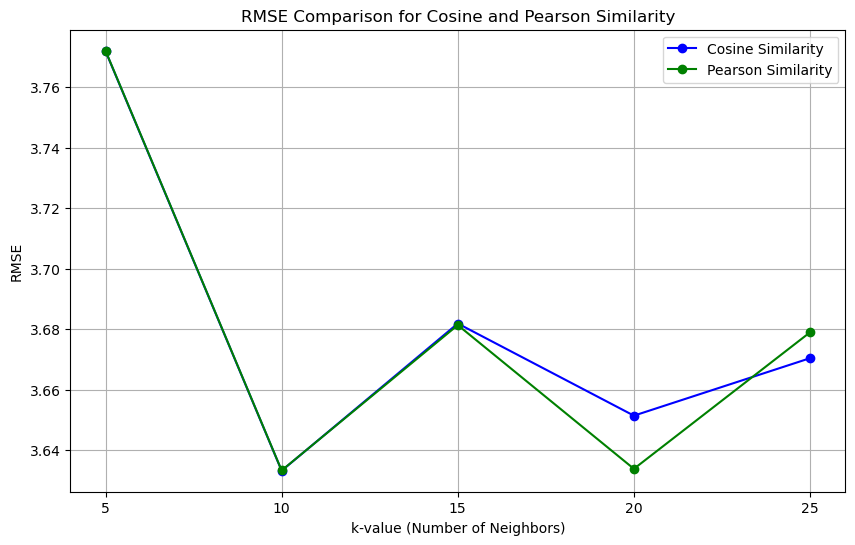

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(K_values, rmse_cosine_values, marker='o', label='Cosine Similarity', color='blue')
plt.plot(K_values, rmse_pearson_values, marker='o', label='Pearson Similarity', color='green')
plt.title('RMSE Comparison for Cosine and Pearson Similarity')
plt.xlabel('k-value (Number of Neighbors)')
plt.ylabel('RMSE')
plt.xticks(K_values) 
plt.legend()  
plt.grid(True)  
plt.show()

# Task 2: Matrix Factorization-based Recommendation

The code below implements a process using the Singular Value Decomposition (SVD) algorithm from the Surprise library to predict movie ratings.

In [6]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

# Prepare the data for suprise library
reader = Reader(rating_scale=(1, 5))
data_sample = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

#Randomly select 5 movies for the test set as per the requirement
np.random.seed(42)
test_movies = np.random.choice(ratings['movie_id'].unique(), 5, replace=False)
print("Selected Test Movies:", test_movies)

# Train-test split while keeping test movies in the test set
train_data = ratings[~ratings['movie_id'].isin(test_movies)]  
test_data = ratings[ratings['movie_id'].isin(test_movies)]  

train_data = Dataset.load_from_df(train_data[['user_id', 'movie_id', 'rating']], reader)
trainset = train_data.build_full_trainset()

# Applying SVD (before tuning)
svd = SVD()
svd.fit(trainset)

#Predicting ratings for test movies
def predict_ratings_for_test(svd_model, test_data):
    actual_ratings = []
    predicted_ratings = []
    
    for _, row in test_data.iterrows():
        user_id = int(row['user_id'])
        movie_id = int(row['movie_id'])
        actual_rating = row['rating']
        predicted_rating = svd_model.predict(user_id, movie_id).est
        
        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)
    
    return actual_ratings, predicted_ratings

# Getting actual and predicted ratings for test movies
actual_ratings, predicted_ratings = predict_ratings_for_test(svd, test_data)

# Calculating the RMSE value before tuning
rmse_before_tuning = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"RMSE before tuning: {rmse_before_tuning}")

Selected Test Movies: [2618 3633 3811  216 3396]
RMSE before tuning: 1.0115822840572373


The RMSE before tuning was around 1.011, which indicates the model's predictions were somewhat off from the true ratings. Therefore, the model needs to be optimised through hyperparameter tuning.

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_factors': [50, 100, 150, 200],
    'lr_all': [0.001, 0.005, 0.01, 0.02],
    'reg_all': [0.02, 0.05, 0.1, 0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)  
gs.fit(data_sample)

# Best parameters and RMSE after tuning
print("Best RMSE after tuning:", gs.best_score['rmse'])
print("Best parameters after tuning:", gs.best_params['rmse'])

# Training the model with the best parameters
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)

# Predicting ratings for the test movies again using the tuned model
actual_ratings_tuned, predicted_ratings_tuned = predict_ratings_for_test(best_svd, test_data)

# Calculating RMSE after tuning
rmse_after_tuning = sqrt(mean_squared_error(actual_ratings_tuned, predicted_ratings_tuned))
print(f"RMSE after tuning: {rmse_after_tuning}")

Best RMSE after tuning: 0.8643985501986003
Best parameters after tuning: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.05}
RMSE after tuning: 0.999814796646802


The above code generates the parameters to be utilized for the lowest RMSE. 


--- RMSE Comparison ---
RMSE before tuning: 1.0115822840572373
RMSE after tuning: 0.999814796646802


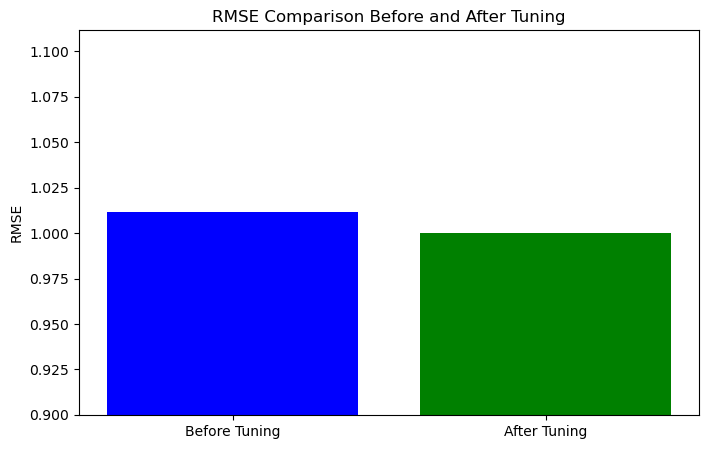

In [8]:
import matplotlib.pyplot as plt

# Step 11: Summary of RMSE comparison
print("\n--- RMSE Comparison ---")
print(f"RMSE before tuning: {rmse_before_tuning}")
print(f"RMSE after tuning: {rmse_after_tuning}")

# Step 12: Plot RMSE Comparison
rmse_values = [rmse_before_tuning, rmse_after_tuning]
labels = ['Before Tuning', 'After Tuning']

plt.figure(figsize=(8, 5))
plt.bar(labels, rmse_values, color=['blue', 'green'])
plt.title('RMSE Comparison Before and After Tuning')
plt.ylabel('RMSE')
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 0.1)  # Adjust y-axis range for better readability

plt.show()

Based on the above output, it can be inferred that the model becomes better after tuning as evidenced by the lower RMSE value. 

# Task 3: Ranking-based Evaluation and Comparison

For this task, we first look at e first load the user-movie ratings dataset and filter out users who have rated more than 100 movies. From this filtered set, 10 users are randomly selected for evaluation. 

Two recommendation models are then employed: a k-nearest neighbors collaborative filtering (KNN-CF) model using cosine similarity, and an Improved Matrix Factorization Recommendation (IMFR) model built using SVD. These models are trained on the full dataset, and we evaluate how well they perform in recommending top-rated movies for the selected users. 

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, ndcg_score
from surprise import KNNBasic, SVD, Dataset, Reader

# Load the ratings data
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=ratings_columns)

# Filter out rows with null ratings, if any
ratings = ratings.dropna(subset=['rating'])

# Define a reader and load the data into the Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Use the full dataset to train the model
trainset = data.build_full_trainset()

# Define similarity options using Pearson correlation
sim_options = {'name': 'cosine', 'user_based': False}
knncf_model = KNNBasic(k=10, sim_options=sim_options)
knncf_model.fit(trainset)

# Define IMFR model with best parameters from Task 2
imfr_model = SVD(n_factors=200, lr_all=0.01, reg_all=0.05)
imfr_model.fit(trainset)

# Select users who have rated more than 100 movies
user_ratings_counts = ratings.groupby('user_id').size()
eligible_users = user_ratings_counts[user_ratings_counts > 100].index

# Randomly select 10 users from this filtered list
np.random.seed(42)
test_users = np.random.choice(eligible_users, 10, replace=False)
print("Selected Test Users:", test_users)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Selected Test Users: [1837 2659 1854  778 1272 5352  692 4509 4907 1057]


Next, for each user, the code generates top-20 movie recommendations using both the KNN-CF and IMFR models. 

In [10]:
# Define a function to get top-20 movie recommendations for a given user and model
def get_top_20_recommendations(model, user_id, movie_ids):
    predictions = []
    for movie_id in movie_ids:
        # Predict rating for each movie
        pred = model.predict(user_id, movie_id).est
        predictions.append((movie_id, pred))
    
    # Sort movies by predicted rating in descending order and select top 20
    top_20 = sorted(predictions, key=lambda x: x[1], reverse=True)[:20]
    return [movie_id for movie_id, _ in top_20]

It then compares these recommendations to the user's actual rated movies (ground truth) and computes AP and NDCG for each model. Finally, the code calculates the average AP and NDCG across all users for both models and outputs the results, allowing a comparison of their ranking quality.

In [11]:
# Create lists to store results
ap_knncf_scores = []
ndcg_knncf_scores = []
ap_imfr_scores = []
ndcg_imfr_scores = []

# Get unique item IDs for recommendation pool
all_movie_ids = ratings['movie_id'].unique()

# Perform evaluation for each test user
for user_id in test_users:
    # Get actual rated movies for this user as ground truth (relevant items)
    user_rated_items = ratings[ratings['user_id'] == user_id]['movie_id'].values
    vector = np.isin(all_movie_ids, user_rated_items).astype(int)  
    
    # KNN-CF Model Recommendations
    top_20_knncf = get_top_20_recommendations(knncf_model, user_id, all_movie_ids)
    knncf_vector = np.isin(all_movie_ids, top_20_knncf).astype(int)
    
    # Calculate AP and NDCG for KNN-CF
    ap_knncf = average_precision_score(vector, knncf_vector)
    ndcg_knncf = ndcg_score([vector], [knncf_vector], k=20)
    ap_knncf_scores.append(ap_knncf)
    ndcg_knncf_scores.append(ndcg_knncf)
    
    # IMFR Model Recommendations
    top_20_imfr = get_top_20_recommendations(imfr_model, user_id, all_movie_ids)
    imfr_vector = np.isin(all_movie_ids, top_20_imfr).astype(int)
    
    # Calculate AP and NDCG for IMFR
    ap_imfr = average_precision_score(vector, imfr_vector)
    ndcg_imfr = ndcg_score([vector], [imfr_vector], k=20)
    ap_imfr_scores.append(ap_imfr)
    ndcg_imfr_scores.append(ndcg_imfr)

# Calculate average AP and NDCG for both models
avg_ap_knncf = np.mean(ap_knncf_scores)
avg_ndcg_knncf = np.mean(ndcg_knncf_scores)
avg_ap_imfr = np.mean(ap_imfr_scores)
avg_ndcg_imfr = np.mean(ndcg_imfr_scores)

# Print results
print("\n--- Ranking Evaluation Results ---")
print("KNN-CF Model - Average Precision:", avg_ap_knncf)
print("KNN-CF Model - NDCG:", avg_ndcg_knncf)
print("IMFR Model - Average Precision:", avg_ap_imfr)
print("IMFR Model - NDCG:", avg_ndcg_imfr)


--- Ranking Evaluation Results ---
KNN-CF Model - Average Precision: 0.09772299899140165
KNN-CF Model - NDCG: 0.47999999999999987
IMFR Model - Average Precision: 0.10195963340016272
IMFR Model - NDCG: 0.5


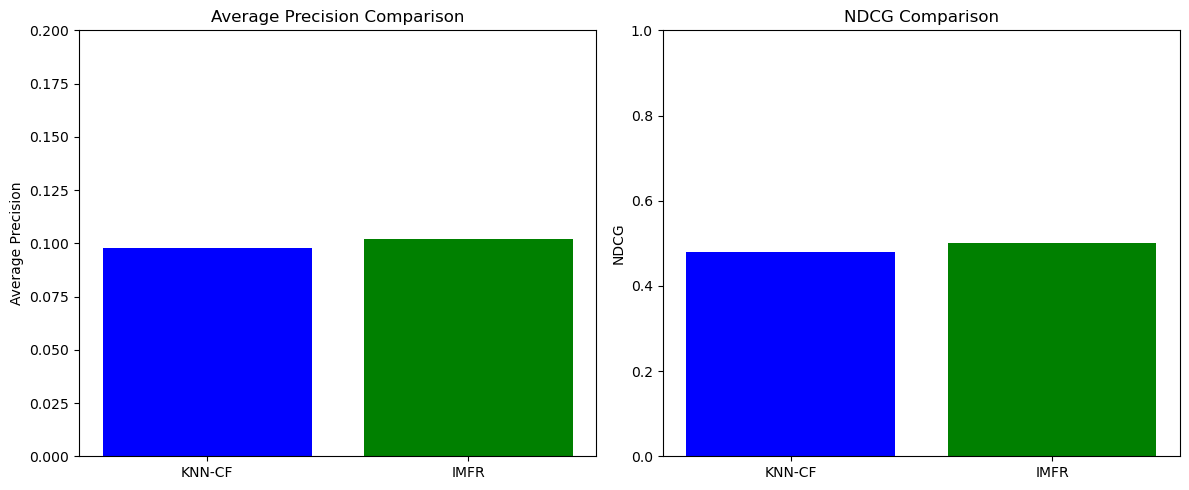

In [12]:
# Create a figure with two subplots: one for AP and one for NDCG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Average Precision (AP)
ax1.bar(['KNN-CF', 'IMFR'], [avg_ap_knncf, avg_ap_imfr], color=['blue', 'green'])
ax1.set_title('Average Precision Comparison')
ax1.set_ylim(0, 0.2)
ax1.set_ylabel('Average Precision')

# Plot for NDCG
ax2.bar(['KNN-CF', 'IMFR'], [avg_ndcg_knncf, avg_ndcg_imfr], color=['blue', 'green'])
ax2.set_title('NDCG Comparison')
ax2.set_ylim(0, 1)
ax2.set_ylabel('NDCG')

# Show the plots
plt.tight_layout()
plt.show()
